# Network size test

Author: Charles Le Losq, Australian National University, 2019.

In this notebook we test how deep vs shallow neural nets perform on a simple problem but with a dataset relatively small and sparse.

We will use Flux.jl in Julia to approach this problem. Another version using scikitlearn is provided.

In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, relu, Chain, ADAM, RMSProp, Descent, params, throttle, Dropout, mse, @epochs, testmode!

using Plots, MLDataUtils

using Base.Iterators: repeated

using BSON: @save, @load
using NNlib

loaded


In [2]:
function f1(x)
    return Float32.(2.0 .*x)
end

f1 (generic function with 1 method)

In [5]:
function f2(x)
    return Float32.(0.9.*x + 5000.0.*cos.(x./30) 
        - 1.0./60.0.*x.^2 
        + 0.00005.*(x.+50).^3 
        + 20000.0.*exp.(-0.5.*((x.-200).^2.0./(100.0.^2)))
        - 20000.0.*exp.(-0.5.*((x.- -500).^2.0./(100.0.^2))))
end

# We create two fake datasets, a linear one, and a weird non-linear problem
x = Float32.([(-900. .- -600.0) .* rand(50) .+ -600.0; 
        (-400. .- -500.0) .* rand(50) .+ -500.0; 
        (100. .- -100.0) .* rand(50) .+ -100.0; 
        (300.0 .- 200.0) .* rand(50) .+ 200.0; 
        (550.0 .- 400.0) .* rand(50) .+ 400.0])
sort!(x)

X_interp = collect(Float32.(-1000:1.0:1000))

y = f2(x)

noise = Float32.(20*randn(length(x)))

nb_data = length(x)

x = reshape(x,1,nb_data)
X_scaler_mean, X_scaler_std = mean(x), std(x)
y_scaler_mean, y_scaler_std = mean(y+noise), std(y+noise)
x_sc = (x.-X_scaler_mean)./(X_scaler_std)
y = reshape(y,1,nb_data)
noise = reshape(noise,1,nb_data)

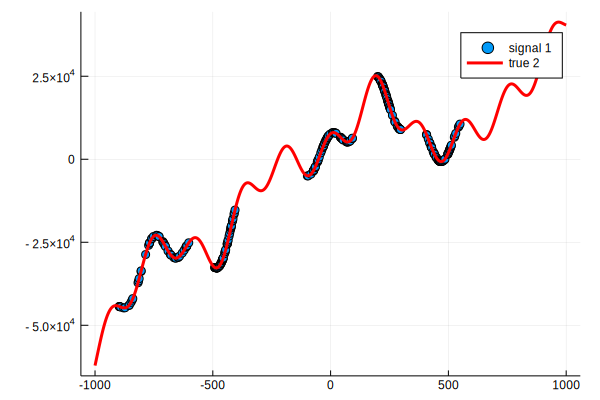

In [12]:
y_sc = (y.-y_scaler_mean)./y_scaler_std

X_interp = reshape(X_interp,1,length(X_interp))
X_interp_sc = (X_interp.-X_scaler_mean)./(X_scaler_std)

scatter(x',y'.+noise',labels=["signal 1"])
plot!(X_interp',f2(X_interp)',label="true 2",line=(:red,3))

In [13]:
N = 200 # number of neurons
layer1 = Dense(1,N,relu)
layer2 = Dense(N,N,relu)
layer3 = Dense(N,N,relu)
layer4 = Dense(N,N,relu)
layer5 = Dense(N,N,relu)
layer6 = Dense(N,N,relu)
layerout = Dense(N,1)

deep = Chain(layer1,#Dropout(0.2),
    layer2,#Dropout(0.2),
    layer3,
    layer4,
    #layer5,
    #layer6,
    layerout)#,Dropout(0.2))

shallow = Chain(Dense(1,1000,tanh),Dense(1000,1))

loss_shallow(x,y) = mse(shallow(x),y)
loss_deep(x,y) = mse(deep(x),y)

loss_deep (generic function with 1 method)

In [17]:
testmode!(deep,false)
opt = ADAM(0.01)
dataset = [(x_sc, y_sc)]

loss_rec_shallow = []
loss_rec_deep = []

evalcb = () -> push!(loss_rec_shallow, loss_shallow(x_sc, y_sc).data)
@epochs 1000  Flux.train!(loss_shallow, params(shallow), dataset,opt, cb = evalcb)

evalcb = () -> push!(loss_rec_deep, loss_deep(x_sc, y_sc).data)
@epochs 1000  Flux.train!(loss_deep, params(deep), dataset,opt, cb = evalcb)

┌ Info: Epoch 1
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 2
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 3
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 4
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 5
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 6
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 7
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 8
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 9
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 10
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 11
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise

┌ Info: Epoch 93
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 94
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 95
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 96
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 97
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 98
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 99
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 100
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 101
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 102
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 103
└ @ Main /home/charles/.julia/packages/Flux/8XpDt

┌ Info: Epoch 183
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 184
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 185
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 186
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 187
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 188
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 189
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 190
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 191
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 192
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 193
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 273
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 274
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 275
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 276
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 277
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 278
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 279
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 280
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 281
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 282
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 283
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 363
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 364
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 365
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 366
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 367
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 368
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 369
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 370
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 371
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 372
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 373
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 453
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 454
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 455
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 456
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 457
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 458
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 459
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 460
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 461
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 462
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 463
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 543
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 544
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 545
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 546
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 547
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 548
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 549
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 550
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 551
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 552
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 553
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 633
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 634
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 635
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 636
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 637
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 638
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 639
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 640
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 641
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 642
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 643
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 723
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 724
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 725
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 726
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 727
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 728
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 729
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 730
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 731
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 732
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 733
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 813
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 814
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 815
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 816
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 817
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 818
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 819
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 820
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 821
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 822
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 823
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 903
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 904
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 905
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 906
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 907
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 908
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 909
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 910
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 911
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 912
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 913
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 993
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 994
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 995
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 996
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 997
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 998
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 999
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 1000
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 1
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 2
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 3
└ @ Main /home/charles/.julia/packages/Flux/8Xp

┌ Info: Epoch 95
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 96
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 97
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 98
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 99
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 100
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 101
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 102
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 103
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 104
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 105
└ @ Main /home/charles/.julia/packages/Flux/8Xp

┌ Info: Epoch 195
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 196
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 197
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 198
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 199
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 200
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 201
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 202
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 203
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 204
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 205
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 285
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 286
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 287
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 288
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 289
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 290
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 291
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 292
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 293
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 294
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 295
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 373
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 374
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 375
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 376
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 377
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 378
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 379
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 380
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 381
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 382
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 383
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 465
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 466
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 467
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 468
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 469
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 470
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 471
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 472
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 473
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 474
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 475
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 559
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 560
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 561
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 562
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 563
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 564
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 565
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 566
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 567
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 568
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 569
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 651
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 652
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 653
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 654
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 655
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 656
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 657
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 658
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 659
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 660
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 661
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 747
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 748
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 749
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 750
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 751
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 752
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 753
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 754
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 755
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 756
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 757
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 843
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 844
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 845
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 846
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 847
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 848
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 849
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 850
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 851
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 852
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 853
└ @ Main /home/charles/.julia/packages/Flu

┌ Info: Epoch 937
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 938
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 939
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 940
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 941
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 942
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 943
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 944
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 945
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 946
└ @ Main /home/charles/.julia/packages/Flux/8XpDt/src/optimise/train.jl:107
┌ Info: Epoch 947
└ @ Main /home/charles/.julia/packages/Flu

In [11]:
# no scaling
# testmode!(deep)
# scatter(x',y'+noise',color=:black,label="observations",xlabel="X",ylabel="Y")
# plot!(X_interp',shallow(X_interp_sc).data'[:],color=:orange,label="shallow")
# plot!(X_interp',deep(X_interp_sc).data'[:],color=:red,label="deep")
# plot!(X_interp',f2(X_interp'),color=:black,label="truth")


In [18]:
testmode!(deep)
scatter(x',y'+noise',color=:black,label="observations",xlabel="X",ylabel="Y")
plot!(X_interp',shallow(X_interp_sc).data'[:].*y_scaler_std.+y_scaler_mean,color=:orange,label="shallow")
plot!(X_interp',deep(X_interp_sc).data'[:].*y_scaler_std.+y_scaler_mean,color=:red,label="deep")
plot!(X_interp',f2(X_interp'),color=:black,label="truth")
#savefig("comp_deep_shallow.pdf")

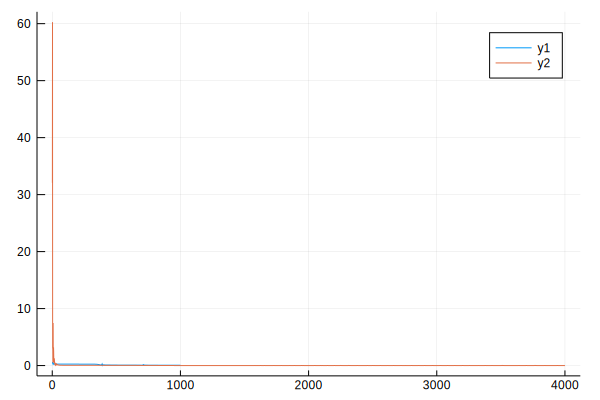

In [217]:
plot(loss_rec_shallow)
plot!(loss_rec_deep)